In [1]:
import argparse
import random
import sys

sys.path.append("../") 
from utils import *
from model import *

import numpy as np 
import scipy.sparse as sp
import os
from batch_visualization import *
import warnings

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("--learning_rate", type=float, default=1e-3, help='Learning rate.')
parser.add_argument("--num_hidden", type=int, default=128, help='Hidden dimension.')
parser.add_argument("--num_proj_hidden", type=int, default=128, help='num_proj_hidden dimension.')
parser.add_argument("--activation", type=str, default='relu', help='activation function')
parser.add_argument("--num_layers", type=int, default=2, help='num layers.')
parser.add_argument("--num_protos", type=int, default=3, help='num of prototypes')
parser.add_argument("--num_changed_edges", type=int, default=50, help='num of added/removed edges')
parser.add_argument("--topology_denoising", type=bool, default=False, help='if scPROTEIN uses topology denoising')
parser.add_argument("--attribute_denoising", type=bool, default=False, help='if scPROTEIN uses topology denoising')
parser.add_argument("--drop_edge_rate_1", type=float, default=0., help='drop_edge_rate_1') 
parser.add_argument("--drop_edge_rate_2", type=float, default=0.1, help='drop_edge_rate_2')  
parser.add_argument("--drop_feature_rate_1", type=float, default=0.1, help='drop_feature_rate_1')   
parser.add_argument("--drop_feature_rate_2", type=float, default=0., help='drop_feature_rate_2')  

parser.add_argument("--threshold", type=float, default=0.075, help='threshold of graph construct')  
parser.add_argument("--tau", type=float, default=0.4, help='tau')
parser.add_argument("--weight_decay", type=float, default=0., help='weight_decay')
parser.add_argument("--num_epochs", type=int, default=200, help='Number of epochs.')
parser.add_argument("--seed", type=int, default=777, help='Random seed.')  
parser.add_argument("--alpha", type=float, default=0.01, help='balance factor')
parser.add_argument("--feature_preprocess", type=bool, default=False, help='feature preprocess')

args =parser.parse_known_args()[0]  
warnings.filterwarnings("ignore")
setup_seed(args.seed)
activation = nn.PReLU() if args.activation == 'prelu' else F.relu


### Load datasets for integration.

Given the names of datasets, datasets will be loaded from folder './integration_dataset' and the protein abundance matrix, cell type and batch indicator will be returned.

In [3]:
batch_label,cell_type_with_dataname,cell_type_label,overlap_cell_type_label, features = integrate_sc_proteomic_features('pSCoPE_Huffman','plexDIA')

overlap celltype: ['HPAFII']
overlap protein nums: 947


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data = graph_generation(features, args.threshold, args.feature_preprocess).to(device)
torch.cuda.empty_cache()
encoder = Encoder(data.num_features, args.num_hidden, activation, k=args.num_layers).to(device)
model = Model(encoder, args.num_hidden, args.num_proj_hidden, args.tau).to(device)

scPROTEIN = scPROTEIN_learning(model,device, data, args.drop_feature_rate_1,args.drop_feature_rate_2,args.drop_edge_rate_1,args.drop_edge_rate_2,
                 args.learning_rate, args.weight_decay, args.num_protos, args.topology_denoising, args.num_epochs, args.alpha, args.num_changed_edges,args.seed)


### scPROTEIN model training

In [5]:
scPROTEIN.train()

(T) | Epoch=001, loss=6.1409 
(T) | Epoch=002, loss=5.6381 
(T) | Epoch=003, loss=5.5256 
(T) | Epoch=004, loss=5.4743 
(T) | Epoch=005, loss=5.5435 
(T) | Epoch=006, loss=5.4515 
(T) | Epoch=007, loss=5.4516 
(T) | Epoch=008, loss=5.4384 
(T) | Epoch=009, loss=5.4244 
(T) | Epoch=010, loss=5.4236 
(T) | Epoch=011, loss=5.4169 
(T) | Epoch=012, loss=5.3945 
(T) | Epoch=013, loss=5.3876 
(T) | Epoch=014, loss=5.3773 
(T) | Epoch=015, loss=5.3689 
(T) | Epoch=016, loss=5.3543 
(T) | Epoch=017, loss=5.3491 
(T) | Epoch=018, loss=5.3309 
(T) | Epoch=019, loss=5.3114 
(T) | Epoch=020, loss=5.3026 
(T) | Epoch=021, loss=5.2672 
(T) | Epoch=022, loss=5.2401 
(T) | Epoch=023, loss=5.2128 
(T) | Epoch=024, loss=5.3075 
(T) | Epoch=025, loss=5.1639 
(T) | Epoch=026, loss=5.2374 
(T) | Epoch=027, loss=5.1318 
(T) | Epoch=028, loss=5.1078 
(T) | Epoch=029, loss=5.0999 
(T) | Epoch=030, loss=5.0978 
(T) | Epoch=031, loss=5.0736 
(T) | Epoch=032, loss=5.1099 
(T) | Epoch=033, loss=5.0559 
(T) | Epoc

### Generate the cell embedding

In [6]:
embedding = scPROTEIN.embedding_generation()
np.save('embedding_pscope_huffman_plexDIA.npy',embedding)

### Evaluate the performance of learned embedding 

We evaluate the performance in terms of both cell clustering and batch correction. For both tasks, higher value indicates a better performance.

In [7]:
celltype_clus(embedding,cell_type_label)

,ASW,ARI,NMI,PS
0,0.521,0.911,0.9,0.962


In [8]:
batch_clus(embedding,cell_type_label,batch_label,overlap_cell_type_label)

,1-ASW,1-ARI,1-NMI,1-PS
0,0.613,0.571,0.566,0.171


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

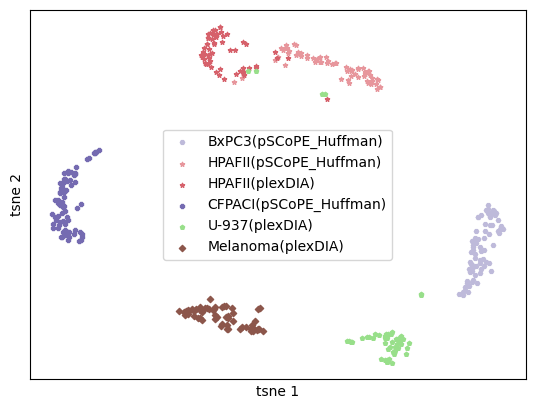

In [9]:
integration_visualization(cell_type_with_dataname,embedding)